<a href="https://colab.research.google.com/github/davisgrubin/2p_imaging/blob/main/Demo%20scripts/Calibrated_spike_inference_with_Cascade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CASCADE

## Calibrated spike inference from calcium imaging data using deep networks
Written and maintained by [Peter Rupprecht](https://github.com/PTRRupprecht) and [Adrian Hoffmann](https://github.com/AdrianHoffmann) from the [Helmchen Lab](https://www.hifo.uzh.ch/en/research/helmchen.html).
The project started as a collaboration of the Helmchen Lab and the [Friedrich Lab](https://www.fmi.ch/research-groups/groupleader.html?group=119). Feedback goes to [Peter Rupprecht](mailto:p.t.r.rupprecht+cascade@gmail.com).

---



This colaboratory notebook runs on servers in the cloud. It uses an algorithm based on deep networks for spike inference (CASCADE, described in this **[Resource Article](https://www.nature.com/articles/s41593-021-00895-5)** published in Nature Neuroscience). Here, you can test the algorithm and use it without any installation on your computer. You just have to sequentially **press the play buttons ("Run cell")** on the left of each box, and the code will be executed.

* If you want to **see the algorithm in action**, just execute the cells without any modifications. Enjoy!

* If you want to **upload your own data**, make predictions and download the saved files, you have to modify the variable names and follow the instructions. Usually no or very little modifications of the code is required.

* If you want to integrate CASCADE into **your local data analysis pipeline**, we suggest you take a look at the [Github repository](https://github.com/HelmchenLabSoftware/Calibrated-inference-of-spiking).

At the end of the notebook, there is a FAQ which answers the most urgent questions (e.g., how do I interpret the results correctly?).

Let's jump in!

##1. Download repository into the Colab Notebook


In [2]:
#@markdown The Github repository with all custom functions, the ground truth datasets and the pretrained models is copied to the environment of this notebook. This will take a couple of seconds.

#@markdown *Note: You can check the code underlying each cell by double-clicking on it.*

import os

# If in Colab and not yet downloaded, download GitHub repository and change working directory
if os.getcwd() == '/content':
    !git clone https://github.com/HelmchenLabSoftware/Cascade
    os.chdir('Cascade')

# If executed as jupyter notebook on own computer, change to parent directory for imports
if os.path.basename( os.getcwd() ) == 'Demo scripts':
    %cd ..
    print('New working directory:', os.getcwd() )

Cloning into 'Cascade'...
remote: Enumerating objects: 3571, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 3571 (delta 182), reused 106 (delta 106), pack-reused 3331 (from 3)
Receiving objects: 100% (3571/3571), 475.66 MiB | 49.59 MiB/s, done.
Resolving deltas: 100% (1124/1124), done.
Updating files: 100% (828/828), done.


##2. Import required python packages


In [3]:
#@markdown Downloads packages from public repository, and packages from Cascade.

%%capture
!pip install ruamel.yaml

# standard python packages
import os, warnings
import glob
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import ruamel.yaml as yaml
yaml = yaml.YAML(typ='rt')

# cascade2p packages, imported from the downloaded Github repository
from cascade2p import checks
checks.check_packages()
from cascade2p import cascade # local folder
from cascade2p.utils import plot_dFF_traces, plot_noise_level_distribution, plot_noise_matched_ground_truth

##3. Define the function to load ΔF/F traces


In [4]:
#@markdown ΔF/F traces must be saved as \*.npy-files (for Python) or \*.mat-files (for Matlab/Python) as a single large matrix named **`dF_traces`** (neurons x time). ΔF/F values of the input should be numeric, not in percent (e.g. 0.5 instead of 50%). For different input formats, the code in this box can be modified (it\'s not difficult).

def load_neurons_x_time(file_path):
    """Custom method to load data as 2d array with shape (neurons, nr_timepoints)"""

    if file_path.endswith('.mat'):
      traces = sio.loadmat(file_path)['dF_traces']
      # PLEASE NOTE: If you use mat73 to load large *.mat-file, be aware of potential numerical errors, see issue #67 (https://github.com/HelmchenLabSoftware/Cascade/issues/67)

    elif file_path.endswith('.npy'):
      traces = np.load(file_path, allow_pickle=True)
      # if saved data was a dictionary packed into a numpy array (MATLAB style): unpack
      if traces.shape == ():
        traces = traces.item()['dF_traces']

    else:
      raise Exception('This function only supports .mat or .npy files.')

    print('Traces standard deviation:', np.nanmean(np.nanstd(traces,axis=1)))
    if np.nanmedian(np.nanstd(traces,axis=1)) > 2:
      print('Fluctuations in dF/F are very large, probably dF/F is given in percent. Traces are divided by 100.')
      return traces/100
    else:
        return traces





##4. Select dataset, indicate frame rate and load ΔF/F traces

In [8]:
#@markdown If you are testing the script, you can leave everything unchanged. If you want to apply the algorithm to your own data, you have to upload your data first. The paragraph above tells you how to format and name the file. You can do this by clicking on the **folder symbol ("Files")** on the left side of the Colaboratory notebook. Next, indicate the path of the uploaded file in the variable **`example_file`**. Finally, indicate the sampling rate of your recordings in the variable **`frame_rate`**.

example_file = "/SA11_20250818.npy" #@param {type:"string"}

frame_rate = 30 #@param {type:"number"}

try:

  traces = load_neurons_x_time( example_file )
  print('Number of neurons in dataset:', traces.shape[0])
  print('Number of timepoints in dataset:', traces.shape[1])

except Exception as e:

  print('\nSomething went wrong!\nEither the target file is missing, in this case please provide the correct location.\nOr your file is not yet completely uploaded, in this case wait until the upload is completed.\n')

  print('Error message: '+str(e))


Traces standard deviation: 0.99997646
Number of neurons in dataset: 242
Number of timepoints in dataset: 106728


##5. Plot distribution of noise levels

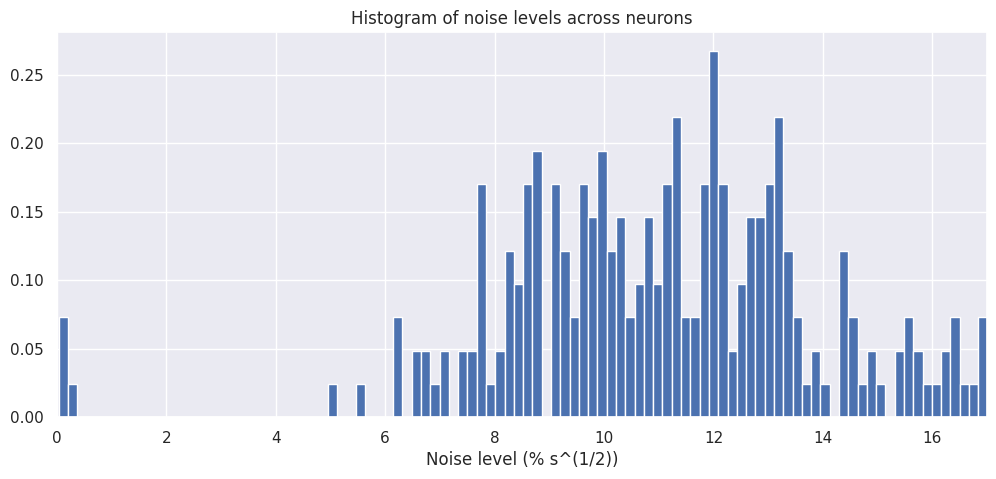

In [9]:
#@markdown For each neuron in the loaded dataset, the noise level will be computed and the distribution across neurons will be shown.
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [12, 5]

noise_levels = plot_noise_level_distribution(traces,frame_rate)



##6. Plot randomly selected calcium traces

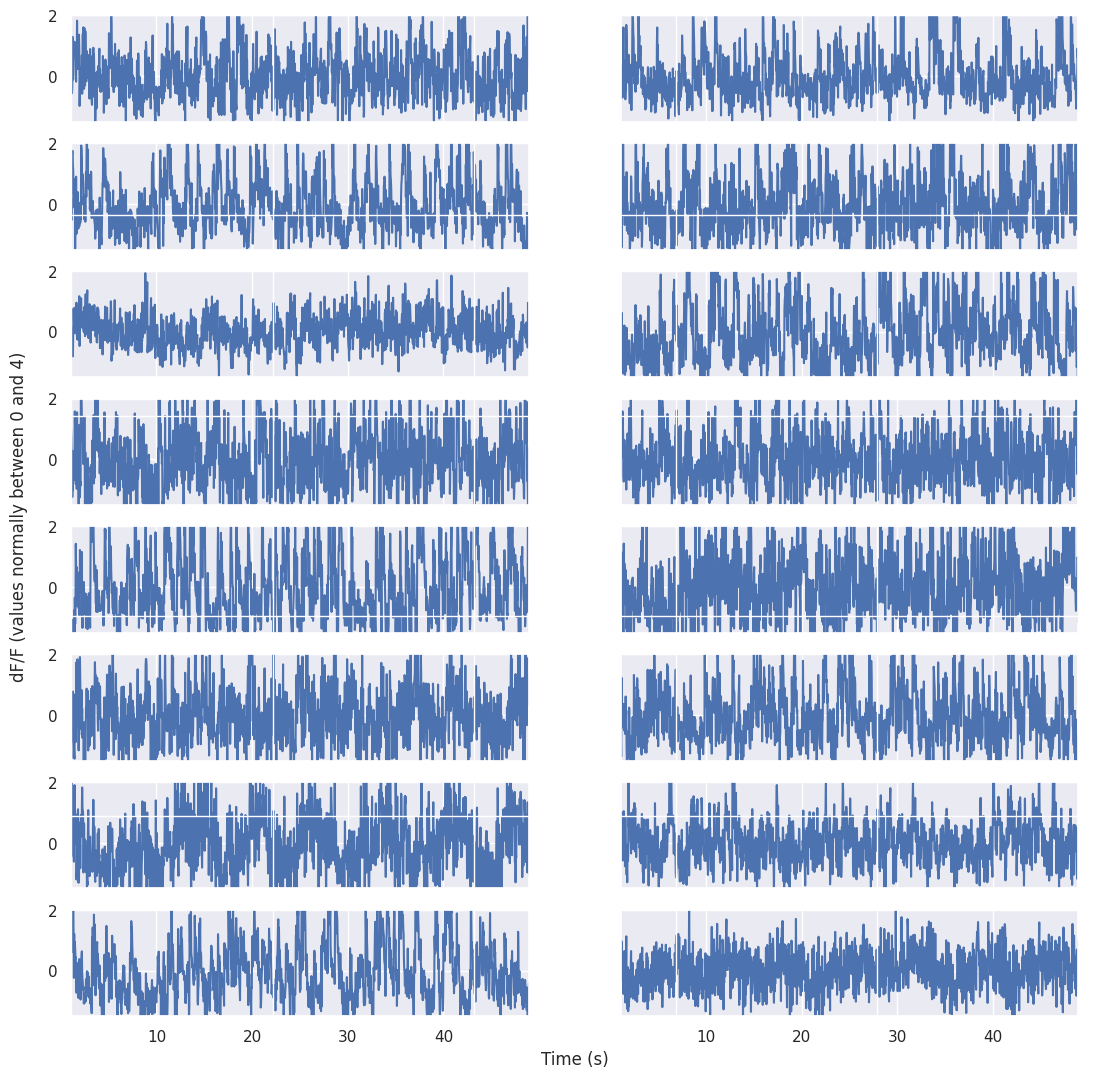

In [10]:
#@markdown Plotting random traces helps to check whether the data have been loaded correctly. If you want to plot specific instead of randomly selected neurons, modify the variable **`neuron_indices`** accordingly.


plt.rcParams['figure.figsize'] = [13, 13]

#np.random.seed(3952)
neuron_indices = np.random.randint(traces.shape[0], size=16)
time_axis = plot_dFF_traces(traces,neuron_indices,frame_rate)




##7. Select pretrained model

In [ ]:
#@markdown Get list of the names of available models.


cascade.download_model( 'update_models',verbose = 1)

yaml_file = open('Pretrained_models/available_models.yaml')
X = yaml.load(yaml_file)
list_of_models = list(X.keys())
print('\n List of available models: \n')
for model in list_of_models:
  print(model)

You can now check the updated available_models.yaml file for valid model names.
File location: /content/Cascade/Pretrained_models/available_models.yaml

 List of available models: 

Global_EXC_1Hz_smoothing500ms
Global_EXC_1Hz_smoothing1000ms
Zebrafish_1Hz_smoothing1000ms
Global_EXC_2Hz_smoothing300ms
Global_EXC_2Hz_smoothing500ms
Global_EXC_2Hz_smoothing1000ms
Global_EXC_2.5Hz_smoothing400ms_high_noise
Global_EXC_3Hz_smoothing400ms
Global_EXC_3Hz_smoothing400ms_high_noise
Global_EXC_3Hz_smoothing400ms_causalkernel
Global_EXC_4.25Hz_smoothing300ms
Global_EXC_4.25Hz_smoothing300ms_high_noise
Global_EXC_4.25Hz_smoothing300ms_causalkernel
Global_EXC_5Hz_smoothing200ms
Global_EXC_5Hz_smoothing200ms_causalkernel
Global_EXC_6Hz_smoothing200ms
Global_EXC_6Hz_smoothing200ms_causalkernel
Global_EXC_7Hz_smoothing200ms
Global_EXC_7Hz_smoothing200ms_causalkernel
Global_EXC_7.5Hz_smoothing200ms_high_noise
Global_EXC_7.5Hz_smoothing200ms
Global_EXC_7.5Hz_smoothing200ms_causalkernel
OGB_zf_pDp_7.5Hz_

In [11]:

#@markdown Select (from the list above) and download the model that fits to your dataset (frame rate, training data; see FAQ for more details) and assign to variable **`model_name`**.

model_name = "GC8f_EXC_30Hz_smoothing50ms_high_noise" #@param {type:"string"}

cascade.download_model( model_name,verbose = 1)

Pretrained model was saved in folder "/content/Cascade/Pretrained_models/GC8f_EXC_30Hz_smoothing50ms_high_noise"


##8. Predict spike rates from ΔF/F traces

In [12]:
#@markdown If this takes too long, make sure that the GPU runtime is activated (*Menu > Runtime > Change Runtime Type*).

total_array_size = traces.itemsize*traces.size*64/1e9

# If the expected array size is too large for the Colab Notebook, split up for processing
if total_array_size < 1:

  spike_prob = cascade.predict( model_name, traces, verbosity=1 )

# Will only be use for large input arrays (long recordings or many neurons)
else:

  print("Split analysis into chunks in order to fit into Colab memory.")

  # pre-allocate array for results
  spike_prob = np.zeros((traces.shape))
  # nb of neurons and nb of chuncks
  nb_neurons = traces.shape[0]
  nb_chunks = int(np.ceil(total_array_size/1))

  chunks = np.array_split(range(nb_neurons), nb_chunks)
  # infer spike rates independently for each chunk
  for part_array in range(nb_chunks):
    spike_prob[chunks[part_array],:] = cascade.predict( model_name, traces[chunks[part_array],:] )


Split analysis into chunks in order to fit into Colab memory.

 
The selected model was trained on 1 datasets, with 5 ensembles for each noise level, at a sampling rate of 30.0Hz, with a resampled ground truth that was smoothed with a Gaussian kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30.0 Hz
Given argument traces contains 35 neurons and 106728 frames.
Noise levels (mean, std; in standard units): 8.87, 2.06

Predictions for noise level 2:
	No neurons for this noise level

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:


	... ensemble 0
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
	... ensemble 1
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
	... ensemble 2
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
	... ensemble 3
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
	... ensemble 4
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step



Predictions for noise level 6:


	... ensemble 0
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 1
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 2
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
	... ensemble 3
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 4
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step



Predictions for noise level 8:


	... ensemble 0
1355/1355 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
	... ensemble 1
1355/1355 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 2
1355/1355 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
	... ensemble 3
1355/1355 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
	... ensemble 4
1355/1355 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step



Predictions for noise level 10:


	... ensemble 0
939/939 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
	... ensemble 1
939/939 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
	... ensemble 2
939/939 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
	... ensemble 3
939/939 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 4
939/939 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step



Predictions for noise level 12:


	... ensemble 0
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
	... ensemble 1
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
	... ensemble 2
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 3
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
	... ensemble 4
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step



Predictions for noise level 14:


	... ensemble 0
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
	... ensemble 1
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
	... ensemble 2
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 3
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 4
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Predictions for noise level 16:
	No neurons for this noise level

Predictions for noise level 19:
	No neurons for this noise level

Predictions for noise level 22:
	No neurons for this noise level

Predictions for noise level 26:
	No neurons for this noise level

Predictions for noise level 30:
	No neurons for this noise level
Spike rate inference done.

 
The selected model was trained on 1 datasets, with 5 ensembles for each noise level, at a sampling rate of 30.0Hz, with a resampled ground truth that was smoothed with a Gaussian kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30.0 Hz
Given argument traces contains 35 neurons and 106728 frames.
Noise levels 


Predictions for noise level 2:
	No neurons for this noise level

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for noise level 6:


	... ensemble 0
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
	... ensemble 1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
	... ensemble 2
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
	... ensemble 3
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
	... ensemble 4
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step



Predictions for noise level 8:


	... ensemble 0
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 1
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 2
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 3
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
	... ensemble 4
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step



Predictions for noise level 10:


	... ensemble 0
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 1
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
	... ensemble 2
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 3
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
	... ensemble 4
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step



Predictions for noise level 12:


	... ensemble 0
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
	... ensemble 1
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 2
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 3
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
	... ensemble 4
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step



Predictions for noise level 14:


	... ensemble 0
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 1
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 2
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 3
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 4
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Predictions for noise level 16:
	No neurons for this noise level

Predictions for noise level 19:
	No neurons for this noise level

Predictions for noise level 22:
	No neurons for this noise level

Predictions for noise level 26:
	No neurons for this noise level

Predictions for noise level 30:
	No neurons for this noise level
Spike rate inference done.

 
The selected model was trained on 1 datasets, with 5 ensembles for each noise level, at a sampling rate of 30.0Hz, with a resampled ground truth that was smoothed with a Gaussian kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30.0 Hz
Given argument traces contains 35 neurons and 106728 frames.
Noise levels 


Predictions for noise level 2:
	No neurons for this noise level

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for noise level 6:
	No neurons for this noise level

Predictions for noise level 8:


	... ensemble 0
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 1
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 2
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
	... ensemble 3
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 4
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step



Predictions for noise level 10:


	... ensemble 0
834/834 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
	... ensemble 1
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
	... ensemble 2
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
	... ensemble 3
834/834 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
	... ensemble 4
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step



Predictions for noise level 12:


	... ensemble 0
939/939 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 1
939/939 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
	... ensemble 2
939/939 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 3
939/939 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 4
939/939 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step



Predictions for noise level 14:


	... ensemble 0
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 1
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
	... ensemble 2
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
	... ensemble 3
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 4
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step



Predictions for noise level 16:


	... ensemble 0
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 1
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 2
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 3
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
	... ensemble 4
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Predictions for noise level 19:
	No neurons for this noise level

Predictions for noise level 22:
	No neurons for this noise level

Predictions for noise level 26:
	No neurons for this noise level

Predictions for noise level 30:
	No neurons for this noise level
Spike rate inference done.

 
The selected model was trained on 1 datasets, with 5 ensembles for each noise level, at a sampling rate of 30.0Hz, with a resampled ground truth that was smoothed with a Gaussian kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30.0 Hz
Given argument traces contains 35 neurons and 106728 frames.
Noise levels (mean, std; in standard units): 10.61, 2.6



Predictions for noise level 2:


	... ensemble 0
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
	... ensemble 1
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
	... ensemble 2
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
	... ensemble 3
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
	... ensemble 4
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step



Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for noise level 6:
	No neurons for this noise level

Predictions for noise level 8:


	... ensemble 0
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 1
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 2
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 3
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 4
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step



Predictions for noise level 10:


	... ensemble 0
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
	... ensemble 1
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
	... ensemble 2
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
	... ensemble 3
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
	... ensemble 4
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step



Predictions for noise level 12:


	... ensemble 0
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 1
834/834 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
	... ensemble 2
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
	... ensemble 3
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
	... ensemble 4
834/834 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step



Predictions for noise level 14:


	... ensemble 0
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 1
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
	... ensemble 2
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
	... ensemble 3
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 4
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step



Predictions for noise level 16:


	... ensemble 0
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 1
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 2
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 3
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
	... ensemble 4
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Predictions for noise level 19:
	No neurons for this noise level

Predictions for noise level 22:
	No neurons for this noise level

Predictions for noise level 26:
	No neurons for this noise level

Predictions for noise level 30:
	No neurons for this noise level
Spike rate inference done.

 
The selected model was trained on 1 datasets, with 5 ensembles for each noise level, at a sampling rate of 30.0Hz, with a resampled ground truth that was smoothed with a Gaussian kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30.0 Hz
Given argument traces contains 34 neurons and 106728 frames.
Noise levels (mean, std; in standard units): 12.0, 1.8



Predictions for noise level 2:
	No neurons for this noise level

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for noise level 6:
	No neurons for this noise level

Predictions for noise level 8:
	No neurons for this noise level

Predictions for noise level 10:


	... ensemble 0
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 1
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
	... ensemble 2
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 3
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 4
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step



Predictions for noise level 12:


	... ensemble 0
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
	... ensemble 1
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
	... ensemble 2
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
	... ensemble 3
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
	... ensemble 4
1564/1564 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step



Predictions for noise level 14:


	... ensemble 0
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 1
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
	... ensemble 2
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 3
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 4
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step



Predictions for noise level 16:


	... ensemble 0
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
	... ensemble 1
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 2
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 3
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 4
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Predictions for noise level 19:
	No neurons for this noise level

Predictions for noise level 22:
	No neurons for this noise level

Predictions for noise level 26:
	No neurons for this noise level

Predictions for noise level 30:
	No neurons for this noise level
Spike rate inference done.

 
The selected model was trained on 1 datasets, with 5 ensembles for each noise level, at a sampling rate of 30.0Hz, with a resampled ground truth that was smoothed with a Gaussian kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30.0 Hz
Given argument traces contains 34 neurons and 106728 frames.
Noise levels (mean, std; in standard units): 12.27, 2.7



Predictions for noise level 2:


	... ensemble 0
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
	... ensemble 1
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
	... ensemble 2
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
	... ensemble 3
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
	... ensemble 4
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step



Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for noise level 6:
	No neurons for this noise level

Predictions for noise level 8:
	No neurons for this noise level

Predictions for noise level 10:


	... ensemble 0
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 1
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 2
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
	... ensemble 3
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 4
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step



Predictions for noise level 12:


	... ensemble 0
1355/1355 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
	... ensemble 1
1355/1355 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 2
1355/1355 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 3
1355/1355 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
	... ensemble 4
1355/1355 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step



Predictions for noise level 14:


	... ensemble 0
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
	... ensemble 1
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 2
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
	... ensemble 3
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
	... ensemble 4
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step



Predictions for noise level 16:


	... ensemble 0
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
	... ensemble 1
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 2
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
	... ensemble 3
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 4
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Predictions for noise level 19:
	No neurons for this noise level

Predictions for noise level 22:
	No neurons for this noise level

Predictions for noise level 26:
	No neurons for this noise level

Predictions for noise level 30:
	No neurons for this noise level
Spike rate inference done.

 
The selected model was trained on 1 datasets, with 5 ensembles for each noise level, at a sampling rate of 30.0Hz, with a resampled ground truth that was smoothed with a Gaussian kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30.0 Hz
Given argument traces contains 34 neurons and 106728 frames.
Noise levels (mean, std; in standard units): 12.96, 3.79



Predictions for noise level 2:


	... ensemble 0
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 1
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 2
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 3
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 4
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step



Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for noise level 6:
	No neurons for this noise level

Predictions for noise level 8:
	No neurons for this noise level

Predictions for noise level 10:


	... ensemble 0
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 1
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 2
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 3
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
	... ensemble 4
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step



Predictions for noise level 12:


	... ensemble 0
1355/1355 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
	... ensemble 1
1355/1355 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 2
1355/1355 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 3
1355/1355 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
	... ensemble 4
1355/1355 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step



Predictions for noise level 14:


	... ensemble 0
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
	... ensemble 1
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
	... ensemble 2
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
	... ensemble 3
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
	... ensemble 4
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step



Predictions for noise level 16:


	... ensemble 0
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
	... ensemble 1
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 2
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
	... ensemble 3
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
	... ensemble 4
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Predictions for noise level 19:
	No neurons for this noise level

Predictions for noise level 22:
	No neurons for this noise level

Predictions for noise level 26:
	No neurons for this noise level

Predictions for noise level 30:
	No neurons for this noise level
Spike rate inference done.


##9. Plot randomly selected example predictions

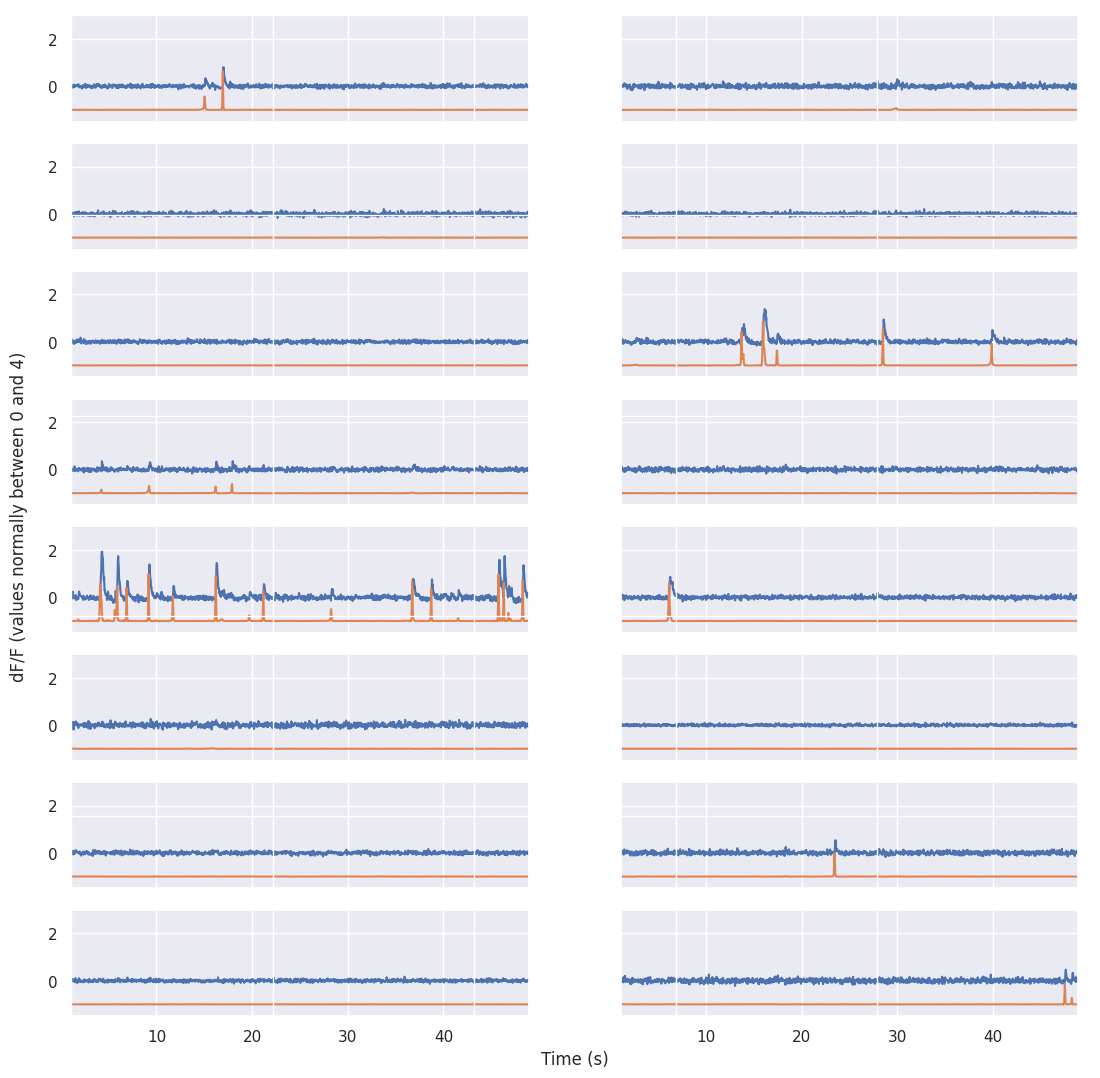

In [ ]:
#@markdown By default plots a set of 16 randomly chosen neuronal traces (first seconds). The dF/F traces are shown in blue, the inferred spike probability is plotted in orange (shifted downwards by 1 for better visibility).

nb_neurons = 16

neuron_indices = np.random.randint(traces.shape[0], size=nb_neurons)
time_axis = plot_dFF_traces(traces,neuron_indices,frame_rate,spike_prob,y_range=(-1.5, 3))

##10. Plot noise-matched examples from the ground truth

In [ ]:
#@markdown Plots randomly drawn excerpts from the ground truth, re-sampled at the same frame rate and noise level as a typical recording of the test dataset. The resampled dF/F signal is shown in blue. The true spike rate convolved with a smoothing kernel is shown in orange (shifted downward by 1 for better visibility).

#@markdown This allows to directly compare **data quality** and **possible artifacts** of training dataset (ground truth) and test dataset (your calcium imaging data).

#@markdown Repeatedly execute this cell to plot new examples.

median_noise = np.round(np.maximum(2,np.median(noise_levels)))
nb_traces = 16
duration = max(time_axis) - 64/frame_rate # seconds
plot_noise_matched_ground_truth( model_name, median_noise, frame_rate, nb_traces, duration )

##11. Save predictions to output file

In [ ]:
#@markdown By default saves as variable **`spike_prob`** both to a *.mat-file and a *.npy-file. You can uncomment the file format that you do not need or leave it as it is.

folder = os.path.dirname(example_file)
file_name = 'predictions_' + os.path.splitext( os.path.basename(example_file))[0]
save_path = os.path.join(folder, file_name)

# save as mat file
sio.savemat(save_path+'.mat', {'spike_prob':spike_prob})

# save as numpy file
np.save(save_path, spike_prob)


# FAQ
## Frequently Asked Question
<a id='FAQ'></a>
Everything you need to know to properly use the above code, to correctly interpret the results, and much more.

---

#### What does the output of the algorithm mean?

>The output **spike_prob** is the _expected number of spikes_ in this time bin, at the same resolution as the original calcium recording. This metric is also called _spike probability_ for brevity in the paper and elsewhere. If you sum over the trace in time, you will get the estimated **number of spikes**. If you multiply the trace with the frame rate, you will get an estimate of the instantaneous **spike rate**. Spike probability and spike rates can therefore be converted by multiplication with the frame rate.

#### Can **spike_prob** be larger than 1?

>Yes. As described above ("What does the output of the algorithm mean?"), the output of the algorithm is strictly speaking not a probability and therefore not restricted to values between 0 and 1. A value >1 indicates that the estimated number of spikes in the time bin is larger than 1.

#### How large would a single spike be?
>This depends on your **frame rate** (Hz) and on the **smoothing** (milliseconds) of your model. Use the following script to compute how the inferred spike probability shape would look like for a single isolated spike for given parameters.
>
>**Smoothing** is the standard deviation of the Gaussian used to smooth the ground truth spike rate before it is used for training. In the file name of a pretrained model, the smoothing parameter is indicated. Read below for more details.




In [ ]:
from scipy.ndimage.filters import gaussian_filter
import numpy as np

sampling_rate = 30 #@param {type:"number"}
smoothing = 50 #@param {type:"number"}

# find out empirically  how large a single AP is
single_spike = np.zeros(1001,)
single_spike[501] = 1
single_spike_smoothed = gaussian_filter(single_spike.astype(float), sigma=smoothing/1e3*sampling_rate)

gaussian_amplitude = np.round(np.max(single_spike_smoothed)*1000)/1000

gaussian_width = np.round(2*np.sqrt(2*np.log(2))*smoothing/1e3*100)/100


print('A single spike in the predictions will have an amplitude of '+str(gaussian_amplitude)+' and a width (FWHM) of '+str(gaussian_width)+' seconds.')


A single spike in the predictions will have an amplitude of 0.266 and a width (FWHM) of 0.12 seconds.


#### How precise and good are my predictions?

>This depends mainly on the **shot noise level** of your dataset. If you want to compute how well the chosen model generalizes to unseen data for a given noise level, check out the Github repository and use [the demo script](https://github.com/HelmchenLabSoftware/Cascade/blob/master/Demo%20scripts/Demo_benchmark_model.py) which computes the performance of a given model.
>
>To get a good idea about the quality of predictions to unseen data, check out **Figure 3** and the associated discussion in the [paper](https://www.nature.com/articles/s41593-021-00895-5).

#### Why is the output of the algorithm a probability, why not discrete spikes?

>Good question! We think that providing spike times instead of spike rates or spiking probabilities is misleading, since it suggests a false precision and certainty of the spiking estimates. In addition, we found (**Fig. S7** in the [paper](https://www.nature.com/articles/s41593-021-00895-5)) that single-spike precision could not achieved with any of the ground truth datasets.
>
>However, for some cases, discrete spikes still might be a good approach. We provide a Python function that converts the spiking probability into the most likely underlying discrete spikes (**[demo](https://github.com/HelmchenLabSoftware/Cascade/blob/master/Demo%20scripts/Demo_discrete_spikes.py)** on Github).


#### Why are the first and last datapoints of the predictions NaNs?

>The deep network uses a window that looks at the calcium trace around the current time point to better understand the context of the current time point. For the first and last points in time, the network is unable to look into the environment and therefore gives back NaNs. If the window size of the network is 64 datapoints (which is the default), the first and last 32 time points will be NaNs.


#### I get a certain noise level for my recordings. What is good or bad?

>For an illustration of different noise levels, check out Extended Data Fig. 3 in the [paper](https://www.nature.com/articles/s41593-021-00895-5). To give an example, the Allen Brain Observatory Visual Coding dataset is of very high imaging quality, with noise levels around **1, which is very good** (unit: $\small \%·s^{-1/2}$ ). A noise level of **3-4 is still decent**, especially for population imaging with many neurons. Noise levels **above 5 indicates rather poor signal** levels. For a definition of the noise level, check out the Methods of the preprint.
>
>However, even for excellent shot noise levels, the recording quality can be bad due to bad imaging resolution, **neuropil contamination** and, most importantly, **movement artifacts**. See Extended Data Fig. 5 in the [paper](https://www.nature.com/articles/s41593-021-00895-5) and the associated text as well as the Discussion for more details.


#### How do I select an appropriate model for my data?

> Each model is trained on a resampled ground truth dataset, as described in the preprint. The training dataset is resampled at the desired frame rate and at multiple noise levels. The model automatically chooses the model with matching noise-levels for each neuron. You only have to select the correct frame rate (which is indicated in the model name).
>
>If you do not have a specific ground truth for your dataset, it is typically best (see Fig. 3 and the associated discussion in the [paper](https://www.nature.com/articles/s41593-021-00895-5)) to use a model that has been trained on all available datasets (called 'Global EXC Model').
>
>There are two additional model specifications that you can choose, "causal" kernels and "smoothing". The choice of these specifications does not make a model better or worse, but better or less well suited for your needs. See the following two questions!

#### What does the **smoothing** parameter for the models mean?

> The ground truth which has been used to train the model has been slightly smoothed with a Gaussian kernel. This is a processing step which helps the deep network to learn quicker and more reliably. However, this also means that the predictions will be smoothed in a similar fashion. How to choose these parameters optimally?
>
> From our experience, at a frame rate of 7.5 Hz, a smoothing kernel with standard deviation of 200 ms is appropriate; for nicely visible transients, also a value of 100 or 50 ms can be tried out, and we have had cases where this was the most satisfying choice of parameters. At 30 Hz, a smoothing kernel of 50 ms works well, but a smoothing kernel of 25 ms could be tried as well if the data quality is good and if one wants to avoid temporally smooth predictions. If the calcium imaging quality is not ideal, it can make sense to increase the smoothing kernel standard deviation. In the end, it is always a trade-off between reliability and optimal learning (more smoothing) and temporal precision (less smoothing of the ground truth). The impact of temporal smoothing on the quality of the inference is discussed in Extended Data Fig. 9 in the [paper](https://www.nature.com/articles/s41593-021-00895-5).
>
> However, if you use our suggested default specifications and your results look useful, you should be good!


#### What does the "causal" mean for some of the models?

> By default, the ground truth is smoothed symmetrically in time. This means, also the predicted spike probabilities are symetrically distributed in time around the true time point. In some cases, this can be a problem because this predicts non-zero neuronal spiking probability before the calcium event had even started. Especially when you want to analyze stimulus-triggered activity patterns, this is an important issue and a common problem for all deconvolution algorithms.
>
> However, if the ground truth is smoothed not with a symmetric Gaussian but with a smooth causal kernel, this limitation can be circumvented (discussed in detail in Fig. S12 in the [paper](https://www.nature.com/articles/s41593-021-00895-5)), and spiking activity is almost exclusively assigned to time points after the calcium event started. It must be noted that this reliable causal re-assignment of activity works well for high-quality datasets, but in case of higher noise levels, any deconvolution algorithm will assign activity to non-causal time points. Good to keep in mind when you interpret your results!


#### None of the models is good for me. What can I do?

> First of all, is this really true? For example, if you have recorded at 30.5 Hz, you can also use a model trained at 30 Hz imaging rates. A deviation by less than 5\% of the imaging rate is totally okay in our experience!
>
> If however you want to use an entirely different model, for example a model trained at a sampling rate of 2 Hz, or a model only trained with a specific ground truth dataset, you have two options. 1) You go to the [Github page](https://github.com/HelmchenLabSoftware/Cascade) and follow the instructions on how to train you own model. This can be done even without GPU-support, but it will take some time (on the other hand, you only have to do this once). 2) You contact us via [e-Mail](mailto:p.t.r.rupprecht+cascade@gmail.com) and tell us what kind of model you would like to have. We will train it for you and upload it to our repository. Not only you, but everybody will then be able to use it further on.



#### I have my own ground truth dataset. How can I use it?

> You have two options.
>
> Either you process the data yourself. You can inspect the ground truth datasets, which consist of Matlab structs saved as a file for each neuron from the [ground truth](https://github.com/HelmchenLabSoftware/Cascade/tree/master/Ground_truth). If you process your ground truth recordings into the same format, you can use it as a training set and train the model yourself. Detailed instructions are provided in the [Github repository](https://github.com/HelmchenLabSoftware/Cascade).
>
> Or you can contact us, and we help to process your dataset if it meets certain quality standards. We can process raw calcium and ephys recordings, but if you can provide extracted dF/F traces and spike times this would of course be even better. Yes, we will do the work for you. But only under the condition that the processed dataset will then be integrated into the published set of ground truth datasets, where it is openly accessible to everybody. Please get in touch with us to discuss options on how to get credit for the recording of the dataset, which we will discuss case by case.

#### I want to use my own ground truth dataset, but I don't want to share it.

> As mentioned, you can process the ground truth dataset yourself. However, we will only help you with the dataset is made public afterwards.


#### Can I use Cascade also locally, *e.g.*, within [CaImAn](https://github.com/flatironinstitute/CaImAn), or in my own pipeline?

> Sure! We have done this ourselves with CaImAn and our custom analysis pipelines. Your starting point to do this will not be this Colaboratory Notebook, but rather the [Github repository](https://github.com/HelmchenLabSoftware/Cascade). Check out the demo Python scripts (*.py). They are very easy to understand and will show you which functions you have to use and how. If you have successfully used this Colaboratory Notebook, understanding the demo scripts will be a piece of cake.

#### Can I use Cascade as well for endoscopic 1p calcium imaging data?

> One of the key features of Cascade is that it infers absolute spike rates. To achieve this, it is necessary that dF/F values extracted from neuronal ROIs are approximately correct. For endoscopic 1p calcium imaging data, the background fluorescence is typically extremely high, and complex methods for subtraction of global or local background activity are used (e.g., by [CNMF-E](https://elifesciences.org/articles/28728)). As also discussed in the CNMF-E paper, extraced traces therefore cannot be properly transformed into dF/F values. We therefore do not recommend Cascade for the deconvolution of this kind of dataset. A purely linear deconvolution algorithm that does not reflect the absolute scaling of the input would be a better choice in such a case, if deconvolution is required.

#### I would like to look at the ground truth data.

> We actually recommend this to anybody who is doing calcium imaging at cellular resolution. Looking at the ground truth data of simultaneous calcium and juxtacellular recording is very enlightening. In the [Github repository](https://github.com/HelmchenLabSoftware/Cascade), we have written an interactive tool to conveniently visualize all ground truth datasets, it is available as a [Colaboratory Notebook](https://colab.research.google.com/github/HelmchenLabSoftware/Cascade/blob/master/Demo%20scripts/Explore_ground_truth_datasets.ipynb).
>
> We recommend to browse through these datasets to any person doing calcium imaging.



#### Which reference should I cite?


> Please cite the [paper](https://www.nature.com/articles/s41593-021-00895-5) as a reference for Cascade:
>
> Rupprecht P, Carta S, Hoffmann A, Echizen M, Blot A, Kwan AC, Dan Y, Hofer SB, Kitamura K, Helmchen F\*, Friedrich RW\*, *A database and deep learning toolbox for noise-optimized, generalized spike inference from calcium imaging*, Nature Neuroscience (2021).
>
> (\* = co-senior authors)
>
>.
>
> If you use the respective ground truth datasets directly, please also refer to the original papers and the associated dataset:
>
> Rupprecht P, Carta S, Hoffmann A, Echizen M, Blot A, AC Kwan, Dan Y, Hofer SB, Kitamura K, Helmchen F\*, Friedrich RW\*, *A database and deep learning toolbox for noise-optimized, generalized spike inference from calcium imaging*, Nature Neuroscience (2021), for datasets \#3-8, \#19 and \#27.
>
> Schoenfeld G, Carta S, Rupprecht P, Ayaz A, Helmchen F, *In vivo calcium imaging of CA3 pyramidal neuron populations in adult mouse hippocampus*, eNeuro (2021), for dataset \#18.
>
> Chen TW, Wardill TJ, Sun Y, Pulver SR, Renninger SL, Baohan A, Schreiter ER, Kerr RA, Orger MB, Jayaraman V, Looger LL. *Ultrasensitive fluorescent proteins for imaging neuronal activity*, Nature (2013), for datasets \#9 and \#14.
>
> Huang L, Ledochowitsch P, Knoblich U, Lecoq J, Murphy GJ, Reid RC, de Vries SE, Koch C, Zeng H., Buice MA, Waters J, Lu Li, *Relationship between simultaneously recorded spiking activity and fluorescence signal in GCaMP6 transgenic mice*, eLife (2021), for datasets \#10, \#11, \#12 and \#13.
>
> Berens P, et al. *Community-based benchmarking improves spike rate inference from two-photon calcium imaging data*, PLoS Comp Biol (2018), for datasets \#1, \#15, \#16.
>
> Akerboom J, Chen TW, Wardill TJ, Tian L, Marvin JS, Mutlu S, Calderón NC, Esposti F, Borghuis BG, Sun XR, Gordus A. *Optimization of a GCaMP calcium indicator for neural activity imaging*, J Neuroscience (2012), for dataset \#17.
>
> Bethge P, Carta S, Lorenzo DA, Egolf L, Goniotaki D, Madisen L, Voigt FF, Chen JL, Schneider B, Ohkura M, Nakai J. *An R-CaMP1.07 reporter mouse for cell-type-specific expression of a sensitive red fluorescent calcium indicator*, PloS ONE (2017), for dataset \#19.
>
> Tada M, Takeuchi A, Hashizume M, Kitamura K, Kano M. *A highly sensitive fluorescent indicator dye for calcium imaging of neural activity in vitro and in vivo*, EJN (2014), for dataset \#3.
>
> Dana H, Mohar B, Sun Y, Narayan S, Gordus A, Hasseman JP, Tsegaye G, Holt GT, Hu A, Walpita D, Patel R. *Sensitive red protein calcium indicators for imaging neural activity*, Elife (2016), for datasets \#20 and \#21.
>
> Khan AG, Poort J, Chadwick A, Blot A, Sahani M, Mrsic-Flogel TD, Hofer SB. *Distinct learning-induced changes in stimulus selectivity and interactions of GABAergic interneuron classes in visual cortex*, Nature Neuroscience (2018), for datasets \#24-26.
>
> Kwan AC, Dan Y. *Dissection of cortical microcircuits by single-neuron stimulation in vivo*, Current Biology (2012), for datasets \#2 and \#22-23.
